### ✅ Notebook Goal:
- Compare the raw OpenFDA MongoDB database with the converted one
- to verify completeness, field preservation, and transformation accuracy

In [23]:
from pymongo import MongoClient
import pandas as pd
from collections import Counter, defaultdict
from pprint import pprint
import random
import matplotlib.pyplot as plt

# --- MongoDB Connections ---
client = MongoClient('mongodb://localhost:27017')
raw_db = client["openfda"]
converted_db = client["openfda_converted"]
raw_collection = raw_db["full_reports"]
converted_collection = converted_db["full_reports"]

In [2]:
# --- 1. Basic Count Comparison ---
raw_count = raw_collection.count_documents({})
converted_count = converted_collection.count_documents({})

print(f"Raw MongoDB reports: {raw_count}")
print(f"Converted MongoDB reports: {converted_count}")

Raw MongoDB reports: 35999
Converted MongoDB reports: 35999


In [4]:
# --- 2. Presence Check for Common Nested Fields ---
def field_presence(collection, path):
    return collection.count_documents({path: {"$exists": True}})

fields_to_check = [
    "patient.reaction",
    "patient.drug",
    "reportduplicate",
    "patient.summary.case_event_date_extracted",
    "patient.drug.openfda",
    "patient.drug.activesubstance"
]

print("\n📊 Field presence comparison:")
for field in fields_to_check:
    raw_count = field_presence(raw_collection, field)
    conv_count = field_presence(converted_collection, field)
    print(f"{field} → Raw: {raw_count}, Converted: {conv_count}")


📊 Field presence comparison:
patient.reaction → Raw: 35999, Converted: 35999
patient.drug → Raw: 35999, Converted: 35999
reportduplicate → Raw: 11561, Converted: 11561
patient.summary.case_event_date_extracted → Raw: 0, Converted: 16948
patient.drug.openfda → Raw: 35670, Converted: 35670
patient.drug.activesubstance → Raw: 35999, Converted: 35999


In [ ]:
# --- 3. Sample Structural Preview ---
print("\n🧬 Sample raw report structure:")
pprint(raw_collection.find_one(), depth=2)

print("\n🧬 Sample converted report structure:")
pprint(converted_collection.find_one(), depth=2)

In [ ]:
# --- 4. Field Coverage Profiling (Sample-based) ---
def extract_field_paths(doc, prefix=""):
    paths = []
    for k, v in doc.items():
        full_path = f"{prefix}.{k}" if prefix else k
        paths.append(full_path)
        if isinstance(v, dict):
            paths.extend(extract_field_paths(v, prefix=full_path))
        elif isinstance(v, list) and v and isinstance(v[0], dict):
            paths.extend(extract_field_paths(v[0], prefix=full_path + "[]"))
    return paths


def profile_field_coverage(collection, sample_size=2000):
    total = collection.count_documents({})
    skip_values = random.sample(range(total), min(sample_size, total))
    counter = defaultdict(int)

    for i, skip in enumerate(skip_values):
        doc = collection.find().skip(skip).limit(1).next()
        seen_fields = set(extract_field_paths(doc))
        for f in seen_fields:
            counter[f] += 1

    df = pd.DataFrame({"field": list(counter.keys()),
                       "presence_count": list(counter.values())})
    df["presence_pct"] = (df["presence_count"] / sample_size * 100).round(2)
    df = df.sort_values("presence_pct", ascending=False).reset_index(drop=True)
    return df

# Run for both collections with larger sample
print("\n🔍 Sampling field coverage in raw collection:")
raw_fields_df = profile_field_coverage(raw_collection, sample_size=10000)

print("\n🔍 Sampling field coverage in converted collection:")
converted_fields_df = profile_field_coverage(converted_collection, sample_size=10000)

# --- 5. Side-by-side comparison ---
merged = pd.merge(raw_fields_df, converted_fields_df, on="field", how="outer", suffixes=("_raw", "_converted"))
merged = merged.fillna(0)
merged["presence_diff"] = (merged["presence_pct_converted"] - merged["presence_pct_raw"]).round(2)
merged = merged.sort_values("presence_pct_raw", ascending=False).reset_index(drop=True)

print("\n📊 Top 30 fields by raw presence with difference compared to converted:")
display(merged.head(30))

In [12]:
merged.to_csv("../../reports/evaluation_results/mongo_field_comparison.csv", index=False)
print("✅ Exported sparse fields to: reports/evaluation_results//mongo_field_comparison.csv")

✅ Exported sparse fields to: reports/evaluation_results//mongo_field_comparison.csv


In [ ]:
# --- 6.1 Field Count Per Report Validation ---
def count_fields_per_document(doc):
    return len(set(extract_field_paths(doc)))

raw_cursor = raw_collection.find({}, {"safetyreportid": 1})
total_checked = 0
total_mismatches = 0

print("\n🔍 Comparing field counts per safetyreportid...")

for raw_doc in raw_cursor:
    sid = int(raw_doc["safetyreportid"])
    full_raw_doc = raw_collection.find_one({"safetyreportid": str(sid)})
    full_conv_doc = converted_collection.find_one({"safetyreportid": sid})
    if not full_raw_doc or not full_conv_doc:
        print(f"⚠️ Safetyreportid {sid} not found in one of the collections.")
        continue

    raw_count = count_fields_per_document(full_raw_doc)
    conv_count = count_fields_per_document(full_conv_doc)

    # Adjust for derived field in converted
    if "summary" in full_conv_doc.get("patient", {}):
        if "case_event_date_extracted" in full_conv_doc["patient"]["summary"]:
            conv_count -= 1

    total_checked += 1
    if raw_count != conv_count:
        total_mismatches += 1
        print(f"❌ Mismatch in safetyreportid {sid}: raw={raw_count}, converted={conv_count}")

print(f"\n✅ Checked {total_checked} reports — {total_mismatches} mismatches found.")
if total_mismatches == 0:
    print("🎉 All field counts match perfectly!")


🔍 Comparing field counts per safetyreportid...

✅ Checked 35999 reports — 0 mismatches found.
🎉 All field counts match perfectly!


In [21]:
# --- 6.2 Field Count Per Report Validation and Export ---
def count_fields_per_document(doc):
    return len(set(extract_field_paths(doc)))

raw_cursor = raw_collection.find({}, {"safetyreportid": 1})
field_counts = []

print("\n🔍 Comparing field counts per safetyreportid...")

for raw_doc in raw_cursor:
    sid = int(raw_doc["safetyreportid"])
    full_raw_doc = raw_collection.find_one({"safetyreportid": str(sid)})
    full_conv_doc = converted_collection.find_one({"safetyreportid": sid})
    if not full_raw_doc or not full_conv_doc:
        continue

    raw_count = count_fields_per_document(full_raw_doc)
    conv_count = count_fields_per_document(full_conv_doc)

    # Adjust for derived field in converted
    if "summary" in full_conv_doc.get("patient", {}):
        if "case_event_date_extracted" in full_conv_doc["patient"]["summary"]:
            conv_count -= 1

    field_counts.append({
        "safetyreportid": sid,
        "field_count_raw": raw_count,
        "field_count_converted": conv_count
    })

field_counts_df = pd.DataFrame(field_counts)
field_counts_df.to_csv("../../reports/evaluation_results/field_counts_by_report.csv", index=False)

print("\n✅ Field count data exported to 'field_counts_by_report.csv'")


🔍 Comparing field counts per safetyreportid...

✅ Field count data exported to 'field_counts_by_report.csv'


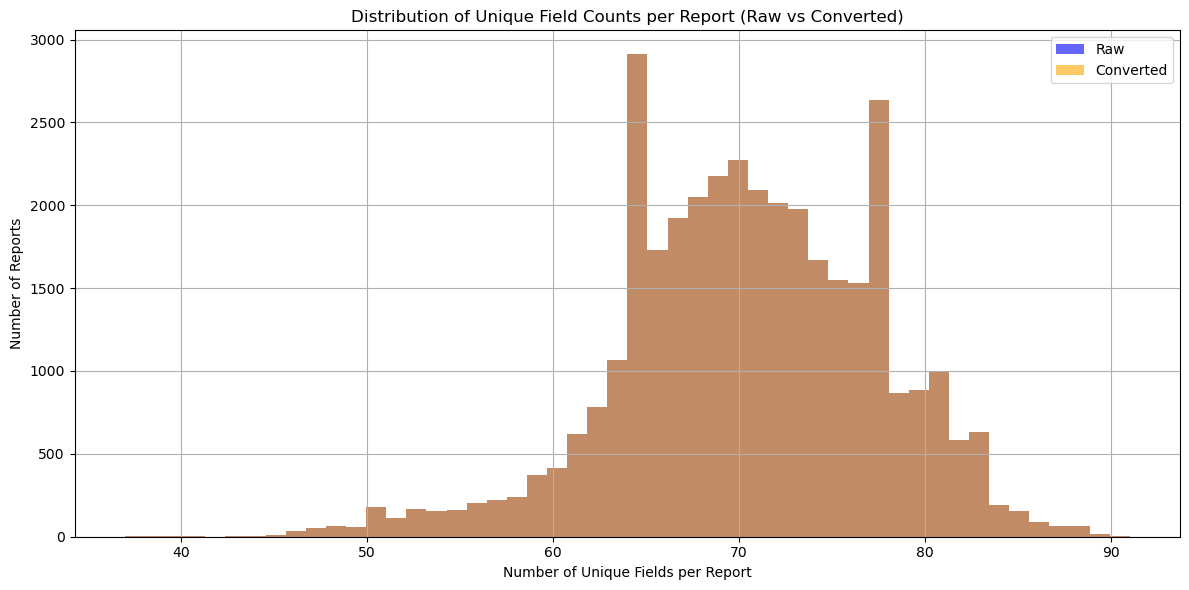

In [24]:
# Load the field count CSV
df = pd.read_csv("../../reports/evaluation_results/field_counts_by_report.csv")

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(df["field_count_raw"], bins=50, alpha=0.6, label="Raw", color="blue")
plt.hist(df["field_count_converted"], bins=50, alpha=0.6, label="Converted", color="orange")
plt.xlabel("Number of Unique Fields per Report")
plt.ylabel("Number of Reports")
plt.title("Distribution of Unique Field Counts per Report (Raw vs Converted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()